# Model Understanding with Captum 使用 Captum 理解模型

请跟随下面的视频或在 [youtube]([youtube](https://www.youtube.com/watch?v=Am2EF9CLu-g)) 上观看。下载 notebook 和对应的文件请点击 [这里]([here](https://pytorch-tutorial-assets.s3.amazonaws.com/youtube-series/video7.zip))。

**Captum**（在拉丁语中意为“理解”）是一个开源的、可扩展的模型解释库，基于 PyTorch 构建。

随着模型复杂度的增加以及透明度的降低，模型可解释性方法变得越来越重要。模型理解既是一个活跃的研究领域，也是跨行业使用机器学习时实践中的关注点。Captum 提供了最先进的算法，包括 Integrated Gradients，帮助研究人员和开发者轻松了解哪些特征对模型输出有贡献。

完整的文档、API 参考以及针对特定主题的教程可以在 [captum.ai](https://captum.ai) 网站找到。

## Introduction 介绍

Captum 对模型可解释性的处理基于**归因（attribution）**。Captum 中有三种归因方法：

- **特征归因（Feature Attribution）**：试图通过输入的特征来解释特定输出。例如，通过某些评论词语解释电影评论是正面还是负面，这就是特征归因的一个例子。

- **层归因（Layer Attribution）**：检查模型隐藏层的活动，作为特定输入的响应。比如，检查卷积层在输入图像后，空间映射的输出就是一个层归因的例子。

- **神经元归因（Neuron Attribution）**：类似于层归因，但聚焦于单个神经元的活动。

在这个交互式笔记本中，我们将探讨**特征归因**和**层归因**。

每种归因类型都有多种归因算法。许多归因算法分为以下两类：

- **基于梯度的算法**：计算模型输出、层输出或神经元激活相对于输入的反向梯度。`Integrated Gradients`（用于特征）、`Layer Gradient * Activation` 和 `Neuron Conductance` 都是基于梯度的算法。

- **基于扰动的算法**：检查输入变化对模型、层或神经元输出的影响。输入扰动可以是定向的或随机的。`Occlusion`、`Feature Ablation` 和 `Feature Permutation` 都是基于扰动的算法。

我们将在下方讨论两种类型的算法。

尤其是在涉及大型模型时，将归因数据可视化为与输入特征相关的方式是非常有价值的。尽管你可以使用 Matplotlib、Plotly 或其他类似工具创建自己的可视化，Captum 提供了特定于其归因的增强工具：

- `captum.attr.visualization` 模块（下方导入为 `viz`）提供了帮助可视化与图像相关的归因功能。
- **Captum Insights** 是 Captum 之上的易于使用的 API，提供了图像、文本和任意模型类型的可视化小部件。

这两种可视化工具集都将在本笔记本中展示。前几个示例将重点放在计算机视觉应用上，而 Captum Insights 部分将在最后展示一个多模型、视觉问答模型的归因可视化。

## 安装

在开始之前，你需要有一个包含以下内容的 Python 环境：

- Python 3.6 或更高版本
- 对于 Captum Insights 示例，Flask 1.1 或更高版本，以及 Flask-Compress（推荐使用最新版本）
- PyTorch 1.2 或更高版本（推荐使用最新版本）
- TorchVision 0.6 或更高版本（推荐使用最新版本）
- Captum（推荐使用最新版本）
- Matplotlib 3.3.4，因为 Captum 目前使用了 Matplotlib 函数，而在更高版本中这些参数已经被重命名

要在 Anaconda 或 pip 虚拟环境中安装 Captum，请使用下方适合你的环境的命令：

### 使用 conda:
```bash
conda install pytorch torchvision captum flask-compress matplotlib=3.3.4 -c pytorch
```
### 使用 pip:
```bash
pip install torch torchvision captum matplotlib==3.3.4 Flask-Compress
```

重启笔记本，配置好你的环境后，你就可以开始了！

## 第一个例子

首先，让我们看一个简单的可视化例子。我们将从一个在 ImageNet 数据集上预训练的 ResNet 模型开始。我们将获取一个测试输入，并使用不同的**特征归因（Feature Attribution）**算法来检查输入图像如何影响输出，并为一些测试图像看到有用的输入归因图的可视化。

首先，进行一些导入操作：

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

现在我们将使用 TorchVision 模型库下载一个预训练的 ResNet 模型。因为我们不会进行训练，所以暂时将其置于评估模式。

In [2]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

你获得此交互式笔记本的地方应该也有一个名为 `img` 的文件夹，里面有一个名为 `cat.jpg` 的文件。

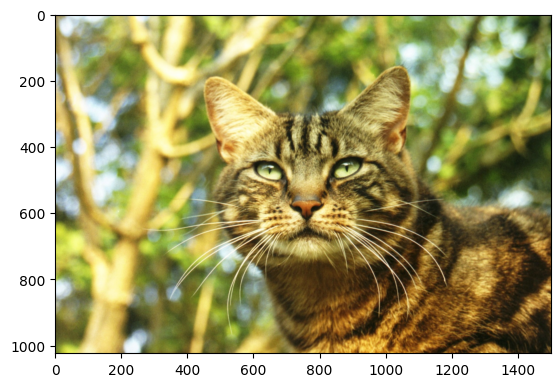

In [3]:
test_img = Image.open('img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

我们的 ResNet 模型是在 ImageNet 数据集上训练的，期望图像的尺寸是特定的，并且通道数据需要归一化到特定的数值范围内。我们还会加载模型能够识别的类别的人类可读标签列表——该列表应该也在 `img` 文件夹中。

In [4]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

现在，我们可以问一个问题：我们的模型认为这张图像代表什么？

In [5]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.5688220262527466 )


我们已经确认ResNet认为我们的猫的图像确实是一只猫。但**为什么**模型认为这是一张猫的图片呢？

为了回答这个问题，我们将转向 Captum。

## Feature Attribution with Integrated Gradients 使用积分梯度进行特征归因

**特征归因** 将特定输出归因于输入的特征。它使用一个特定的输入（在这里是我们的测试图像）来生成每个输入特征对特定输出特征的相对重要性图。

[积分梯度](https://captum.ai/api/integrated_gradients.html)是 Captum 中可用的特征归因算法之一。积分梯度通过近似模型输出对输入的梯度积分，为每个输入特征分配一个重要性得分。

在我们的例子中，我们将取输出向量的一个特定元素，也就是指示模型对所选类别的置信度的那个元素，使用积分梯度来理解输入图像的哪些部分对该输出产生了贡献。

一旦我们从积分梯度获得了重要性图，我们将使用 Captum 中的可视化工具来显示重要性图的可视化表示。Captum 的 `visualize_image_attr()` 函数提供了多种选项，用于自定义归因数据的显示。这里，我们传入了一个自定义的 Matplotlib 颜色映射。

运行包含 `integrated_gradients.attribute()` 的代码单元通常需要一两分钟。

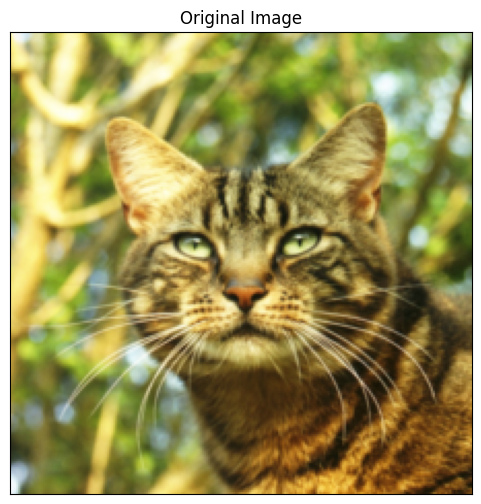

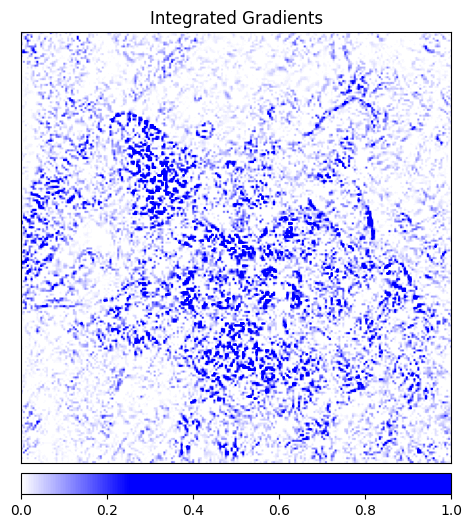

In [6]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

在上面的图片中，您应该能看到积分梯度（Integrated Gradients）为图像中猫的位置提供了最强的信号。

## Feature Attribution with Occlusion 使用Occlusion法进行特征归因

基于梯度的归因方法帮助我们理解模型，解释输出是如何随着输入的变化而改变的。而基于扰动的归因方法则更为直接，通过引入对输入的改变来衡量这些变化对输出的影响。遮挡法（Occlusion）就是一种这样的方法，它涉及替换输入图像的部分区域，并检查这些区域对输出信号的影响。

在下面，我们设置了遮挡归因。与配置卷积神经网络类似，你可以指定目标区域的大小以及步长长度，用以确定单次测量之间的间距。我们将通过 `visualize_image_attr_multiple()` 函数可视化遮挡归因的输出，显示区域中正向和负向归因的热力图，并通过掩盖原始图像的正向归因区域，展示模型认为最具“猫科特征”的图像区域。  

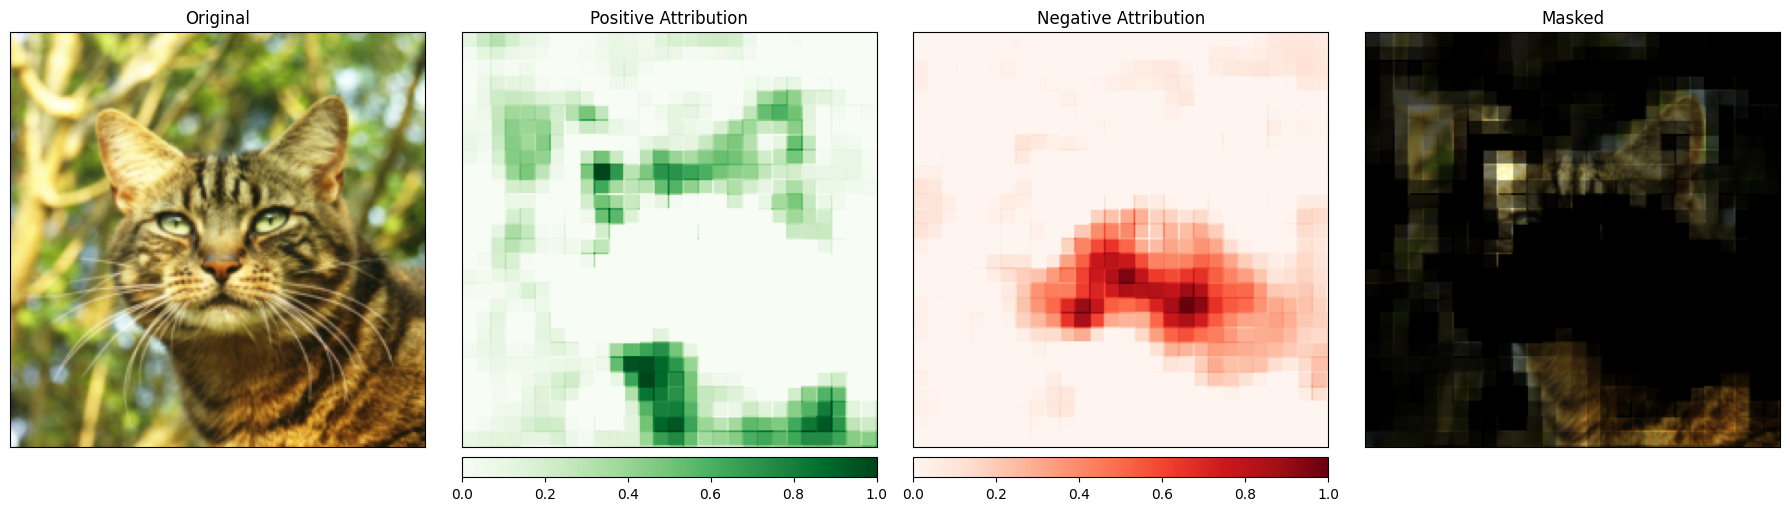

In [7]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

再次，我们看到模型对包含猫的图像区域赋予了更大的重要性。

## Layer Attribution with Layer GradCAM 使用 Layer GradCAM 进行层归因

**层归因**允许您将模型中隐藏层的活动归因于输入的特征。下面，我们将使用层归因算法来检查模型中卷积层之一的活动。

GradCAM 计算目标输出相对于给定层的梯度、每个输出通道（输出的维度 2）的平均值，并将每个通道的平均梯度乘以层激活。将所有通道的结果相加。 GradCAM 是为卷积网络设计的；由于卷积层的活动通常在空间上映射到输入，因此 GradCAM 属性通常会被上采样并用于屏蔽输入。

层归因的设置与输入归因类似，不同之处在于除了模型之外，您还必须在模型中指定要检查的隐藏层。如上所述，当我们调用`attribute()`时，我们指定感兴趣的目标类。

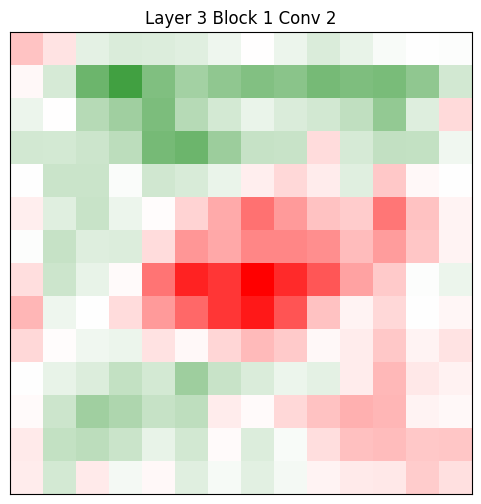

In [8]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

我们将使用[LayerAttribution](https://captum.ai/api/base_classes.html?highlight=layerattribution#captum.attr.LayerAttribution)基类中的便捷方法`interpolate()`来对该属性数据进行上采样，以便与输入图像进行比较。

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


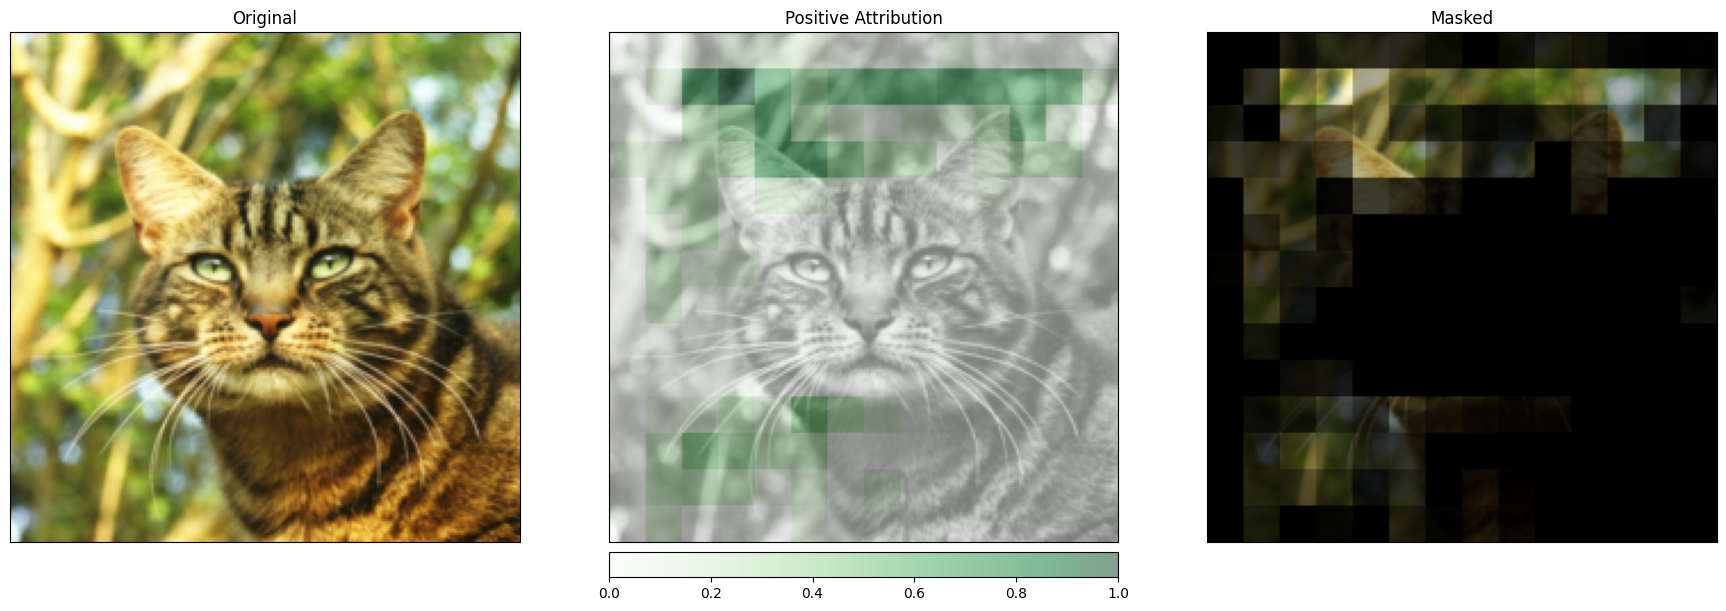

In [9]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

诸如此类的可视化可以让你对隐藏层如何响应输入有新的见解。

## Visualization with Captum Insights 利用 Captum Insights 进行可视化

Captum Insights 是一个构建在 Captum 之上的可解释性可视化小部件，旨在促进模型理解。 Captum Insights 跨图像、文本和其他特征工作，帮助用户了解特征归因。它允许您可视化多个输入/输出对的归因，并提供图像、文本和任意数据的可视化工具。

在notebook的这一部分中，我们将使用 Captum Insights 可视化多个图像分类推理。

首先，让我们收集一些图像，看看模型对它们的看法。为了增加多样性，我们将带上我们的猫、茶壶和三叶虫化石：

In [10]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.5688220262527466 )
Predicted: teapot / 849  ( 0.9914801120758057 )
Predicted: trilobite / 69  ( 0.9999061822891235 )


看起来我们的模型正确地识别了它们 - 但当然，我们想更深入地挖掘。为此，我们将使用 Captum Insights 小部件，我们使用下面导入的`AttributionVisualizer`对象对其进行配置。 `AttributionVisualizer`需要批量数据，因此我们将引入 `Captum` 的`Batch`帮助程序类。我们将专门查看图像，因此我们还将导入`ImageFeature` 。

我们使用以下参数配置`AttributionVisualizer ：`

- 一系列要检查的模型（在我们的例子中，只有一个）
- 评分函数，允许 Captum Insights 从模型中提取前 k 个预测
- 我们的模型所训练的类的有序的、人类可读的列表
- 要查找的特征列表 - 在我们的例子中是ImageFeature
- 数据集，它是一个可迭代对象，返回批量输入和标签 - 就像您用于训练一样

In [11]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

请注意，与上面的归因不同，运行上面的单元格根本不需要太多时间。这是因为 Captum Insights 允许您在可视化小部件中配置不同的归因算法，然后它将计算并显示归因。该过程将需要几分钟。

运行下面的单元格将呈现 Captum Insights 小部件。然后，您可以选择归因方法及其参数，根据预测类别或预测正确性过滤模型响应，查看模型的预测以及相关概率，并查看与原始图像相比的归因热图。

In [12]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()